In [1]:
from Utils import *
from import_data import * 

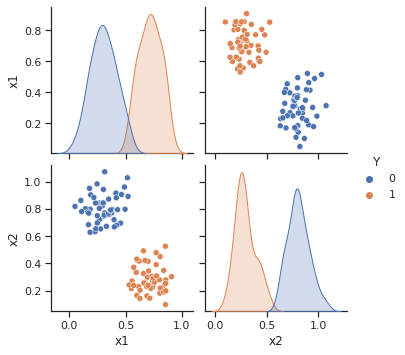

In [2]:
# X, Y = load_iris(fraction=.5)
X, Y = load_bivariate_gaussian(n_train=100)
# X,Y = load_parity(plot=True)
# X,Y = load_moon(fraction=.4, plot=True)

In [3]:
# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.nan_to_num((np.array([get_angles(x) for x in X_norm])))
print("First features sample      :", features[0])

First X sample (padded)    : [0.27753342 0.65450937 0.3        0.        ]
First X sample (normalized): [0.3596733  0.84822054 0.38878918 0.        ]
First features sample      : [ 0.79863404 -0.          0.         -1.16974522  1.16974522]


In [4]:
# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[0])

First X sample (normalized): [0.39038626 0.92065117]


In [5]:
def get_Sx(ang=None, x=None, pad=False):
    backend = Aer.get_backend('unitary_simulator')

    if pad==True:
        q = QuantumRegister(2)
        circuit = QuantumCircuit(q)
        circuit = state_preparation(ang, circuit, [0, 1])
    elif pad==False:
        x = x.astype(complex)
        q = QuantumRegister(1)
        circuit = QuantumCircuit(q)
        circuit.initialize(x, [q])

    job = execute(circuit, backend)
    result = job.result()
    U = result.get_unitary(circuit)
    S = Operator(U)
    return S

In [6]:
def linear_operator(param, pad=False):
    backend = Aer.get_backend('unitary_simulator')
    '''pad variable influences the size of params vector'''
    if pad==True:
        data = QuantumRegister(2)
        qc = QuantumCircuit(data_reg)
        qc.u3(param[0], param[1], param[2], data[0])
        qc.u3(param[3], param[4], param[5], data[1])
        qc.cx(data[0], data[1])
    elif pad==False:
        data = QuantumRegister(1)
        qc = QuantumCircuit(data)
        qc.u3(param[0], param[1], param[2], data)

    job = execute(qc, backend)
    result = job.result()

    U = result.get_unitary(qc)
    G = Operator(U)
    return G


In [7]:

def sigma(pad=False):
    backend = Aer.get_backend('unitary_simulator')
    if pad==True:
        data = QuantumRegister(2)
        qc = QuantumCircuit(data)
        qc.id(data)
    if pad==False:
        data = QuantumRegister(1)
        qc = QuantumCircuit(data)
        qc.id(data)

    job = execute(qc, backend)
    result = job.result()

    U = result.get_unitary(qc)
    I = Operator(U)
    return I

In [8]:

def R_gate(beta):
    backend = Aer.get_backend('unitary_simulator')
    control = QuantumRegister(1)
    qc = QuantumCircuit(control)
    qc.ry(beta, control)

    job = execute(qc, backend)
    result = job.result()

    U = result.get_unitary(qc)
    R = Operator(U)
    return R


In [9]:
def create_circuit(parameters=None, x=None, pad=False):
    beta = parameters[0]
    theta1 = parameters[1:4]
    theta2 = parameters[4:7]

    control = QuantumRegister(1, 'control')
    data = QuantumRegister(1, 'x')
    temp = QuantumRegister(1, 'temp')
    c = ClassicalRegister(1)
    qc = QuantumCircuit(control, data, temp, c)

    S=get_Sx(x=x)
    qc.unitary(S, data, label='$S_{x}$')

    R=R_gate(beta)
    qc.unitary(R, control, label='$R_{Y}(β)$')

    qc.barrier()
    qc.cswap(control, data, temp)

    G1 = linear_operator(theta1)
    qc.unitary(G1, data, label='$G(θ_{1})$')

    G2 = linear_operator(theta2)
    qc.unitary(G2, temp, label='$G(θ_{2})$')

    qc.cswap(control, data, temp)
    qc.barrier()

    sig = sigma()
    qc.unitary(sig, data, label='$Σ$')

    qc.barrier()
    qc.measure(data[0], c)
    return qc



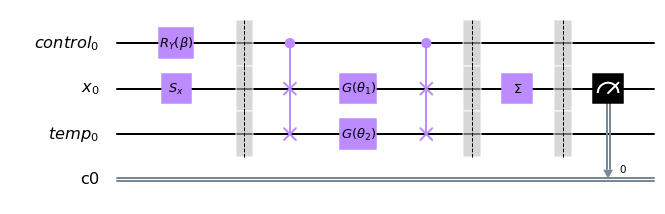

In [10]:
c=create_circuit(parameters=range(7), x=np.array([0,1]))
c.draw(output='mpl')

In [11]:
def execute_circuit(parameters, x=None, shots=1000, print=False):
    backend = BasicAer.get_backend('qasm_simulator')

    circuit=create_circuit(parameters, x)
    if print:
        circuit.draw(output='mpl')
        plt.show()
    result = execute(circuit, backend, shots=shots).result()

    counts = result.get_counts(circuit)
    result = np.zeros(2)
    for key in counts:
        result[int(key, 2)] = counts[key]
    result /= shots
    return result[1]



def cost(params, X, labels):
    predictions = [execute_circuit(params, x) for x in X]
    return binary_crossentropy(labels, predictions)

In [17]:
X = X_norm.copy()
# seed = 974 # iris:359, gaussian:527
# seed=np.random.randint(0,10**3,1)[0]
np.random.seed(seed)
current_params = (0.1*np.random.randn(7))

from qiskit.aqua.components.optimizers import AQGD
optimizer_step = AQGD(maxiter=1, eta=2.0, disp=False)
execute_circuit(current_params, x=X[2], print=True)


num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
X_train = X[index[:num_train]]
Y_train = Y[index[:num_train]]
X_val = X[index[num_train:]]
Y_val = Y[index[num_train:]]
batch_size = 20
T = 20
acc_final_tr = 0
acc_final_val = 0

In [18]:
optimizer_step = AQGD(maxiter=20, eta=2.0, disp=True)

obj_function = lambda params: cost(params, X_train, Y_train)
point, value, nfev = optimizer_step.optimize(len(current_params), obj_function, initial_point=current_params)

Iteration: 0 	| Energy: 0.9683539520406849
Iteration: 1 	| Energy: 0.43628815555287237
Iteration: 2 	| Energy: 0.030832286988508272
Iteration: 3 	| Energy: 0.19852335238122457
Iteration: 4 	| Energy: 0.0074304541758495575
Iteration: 5 	| Energy: 0.06136634182179496
Iteration: 6 	| Energy: 0.02974981944515813
Iteration: 7 	| Energy: 0.006447126016751225
Iteration: 8 	| Energy: 0.012635154505269797
Iteration: 9 	| Energy: 0.009550480446745679
Iteration: 10 	| Energy: 0.00654634812331185
Iteration: 11 	| Energy: 0.007286724528564494
Iteration: 12 	| Energy: 0.006905262893395459
Iteration: 13 	| Energy: 0.006346097367189636
Iteration: 14 	| Energy: 0.006228079109418001
Iteration: 15 	| Energy: 0.006776170286452481
Iteration: 16 	| Energy: 0.006268910945127688
Iteration: 17 	| Energy: 0.0065794619687028965
Iteration: 18 	| Energy: 0.006220445843958924
Iteration: 19 	| Energy: 0.0061049026543931574
Iteration: 20 	| Energy: 0.006151476752502219


In [ ]:
for i in range(T):
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]

    obj_function = lambda params: cost(params, X_batch, Y_batch)
    point, value, nfev = optimizer_step.optimize(len(current_params), obj_function,
                                                 initial_point=current_params)
    current_params = point
    print(
        "Iter: {:5d} | Cost: {:0.7f}"
        "".format(i + 1, cost(current_params, X_train, Y_train)))

    # Compute predictions on train and validation set
    # probs_train = [execute_circuit(point, x) for x in X_train]
    # probs_val = [execute_circuit(point, x) for x in X_val]

    # predictions_train = [predict(p) for p in probs_train]
    # predictions_val = [predict(p) for p in probs_val]

    # acc_train = accuracy(Y_train, predictions_train)
    # acc_val = accuracy(Y_val, predictions_val)

#     if acc_final_tr < acc_train:
#         best_param = point
#         acc_final_tr = acc_train
#         acc_final_val = acc_val
#         best_seed = seed
#         iteration = i

#     print(
#         "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.3f} | Acc validation: {:0.3f} "
#         "".format(i + 1, cost(point, X_train, Y_train), acc_train, acc_val))

In [16]:
probs_train = [execute_circuit(point, x) for x in X_train]
probs_val = [execute_circuit(point, x) for x in X_val]

predictions_train = [predict(p) for p in probs_train]
predictions_val = [predict(p) for p in probs_val]

acc_train = accuracy(Y_train, predictions_train)
acc_val = accuracy(Y_val, predictions_val)

print("Final model: Cost: {:0.7f} | Acc train: {:0.3f} | Acc validation: {:0.3f} "
      "".format(cost(point, X_train, Y_train), acc_train, acc_val))

Final model: Cost: 0.0079796 | Acc train: 0.773 | Acc validation: 0.840 


In [ ]:
probs_train = [execute_circuit(point, x) for x in X_train]
probs_val = [execute_circuit(point, x) for x in X_val]

predictions_train = [predict(p) for p in probs_train]
predictions_val = [predict(p) for p in probs_val]

acc_train = accuracy(Y_train, predictions_train)
acc_val = accuracy(Y_val, predictions_val)

print("Final model: Cost: {:0.7f} | Acc train: {:0.3f} | Acc validation: {:0.3f} "
      "".format(cost(current_params, X_train, Y_train), acc_train, acc_val))

In [ ]:
print("Final model: Cost: {:0.7f} | Acc train: {:0.3f} | Acc validation: {:0.3f} "
      "".format(cost(current_params, X_train, Y_train), acc_final_tr, acc_final_val))